<a href="https://colab.research.google.com/github/Sarvesh072/Stock_Trading_bot_mark1/blob/main/StockTradingBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install alpaca-trade-api numpy pandas tensorflow tensorflow_probability
!pip install cohere openai tiktoken
!pip install --upgrade llmx

In [3]:
import alpaca_trade_api as tradeapi
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from datetime import datetime

# Alpaca API credentials
APCA_API_BASE_URL = 'https://paper-api.alpaca.markets'  # Use the paper trading API for testing
APCA_API_KEY_ID = 'PKZA212GGBDLAHBNNZ3P'
APCA_API_SECRET_KEY = 'n2OnYP4RMhUnUTyCby9TJExJSN06h9tldeEtWnoo'


api = tradeapi.REST(APCA_API_KEY_ID, APCA_API_SECRET_KEY, APCA_API_BASE_URL, api_version='v2')


In [4]:
import numpy as np
import os

chkpt_dir = 'models/'
actor_path = os.path.join(chkpt_dir, 'actor')
critic_path = os.path.join(chkpt_dir, 'critic')

class StockTradingEnv:
    def __init__(self, df):
        self.df = df
        self.current_step = 0
        self.max_steps = len(df) - 1
        self.initial_balance = 10000  # Set an initial balance for your trading agent
        self.current_balance = self.initial_balance
        self.position = 0  # Number of shares currently held
        self.transaction_cost_pct = 0.001  # Transaction cost as a percentage of the transaction amount

    def reset(self):
        self.current_step = 0
        self.current_balance = self.initial_balance
        self.position = 0
        return np.array([self._get_observation()])

    def _get_observation(self):
        observation = self.df.iloc[self.current_step].copy()

        # Convert datetime.date objects to timestamp and then to numeric value
        for col in observation.index:
            if type(observation[col], datetime.date):
                observation[col] = observation[col].toordinal()

        return observation.values.astype(np.float32)

    def step(self, action):
        self.current_step += 1

        if self.current_step > self.max_steps:
            done = True
        else:
            done = False

        obs = self._get_observation()
        reward, transaction_cost = self._calculate_reward(action)
        self.current_balance -= transaction_cost
        self.position += action  # Assuming action is the number of shares bought (+) or sold (-)

        return np.array([obs]), reward, done, {}

    def _calculate_reward(self, action):
        current_price = self.df['Close'].iloc[self.current_step]
        previous_price = self.df['Close'].iloc[self.current_step - 1]
        price_change_pct = (current_price - previous_price) / previous_price
        transaction_amount = abs(action) * current_price
        transaction_cost = transaction_amount * self.transaction_cost_pct

        # Reward is the change in portfolio value (including transaction cost)
        reward = self.current_balance + self.position * current_price - transaction_cost - self.initial_balance

        return reward, transaction_cost


# Define the PPOMemory class
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
            np.array(self.actions),\
            np.array(self.probs),\
            np.array(self.vals),\
            np.array(self.rewards),\
            np.array(self.dones),\
            batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []


# Define the ActorNetwork class
class ActorNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorNetwork, self).__init__()

        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.flatten = Flatten()
        self.fc3 = Dense(n_actions, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.flatten(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


# Define the CriticNetwork class
class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=256, fc2_dims=256):
        super(CriticNetwork, self).__init__()
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.flatten = Flatten()
        self.q = Dense(1, activation=None)

    def call(self, state):
        x = self.fc1(state)
        x = self.flatten(x)
        x = self.fc2(x)
        q = self.q(x)

        return q


# Define the Agent class
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003,
                 gae_lambda=0.95, policy_clip=0.2, batch_size=64,
                 n_epochs=10, chkpt_dir='models/'):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.chkpt_dir = chkpt_dir

        self.actor = ActorNetwork(n_actions)
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic = CriticNetwork()
        self.critic.compile(optimizer=Adam(learning_rate=alpha))
        self.memory = PPOMemory(batch_size)

    def store_transition(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save(self.chkpt_dir + 'actor')
        self.critic.save(self.chkpt_dir + 'critic')

    def load_models(self):
        print('... loading models ...')
        try:
            self.actor = keras.models.load_model(self.chkpt_dir + 'actor')
            self.critic = keras.models.load_model(self.chkpt_dir + 'critic')
            print('Models loaded successfully.')
        except Exception as e:
            print('Error loading models:', e)

    def choose_action(self, observation):
        state = tf.convert_to_tensor(observation)

        probs = self.actor(state)
        dist = tfp.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state)

        action = action.numpy()[0]
        value = value.numpy()[0]
        log_prob = log_prob.numpy()[0]

        return action, log_prob, value

    def _get_observation(self, env):
        observation = env.reset()  # Assuming you can reset the environment to obtain the initial observation
        return np.array([observation])

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
                reward_arr, dones_arr, batches = \
                self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1] * (
                        1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t

            for batch in batches:
                with tf.GradientTape(persistent=True) as tape:
                    states = tf.convert_to_tensor(state_arr[batch])
                    old_probs = tf.convert_to_tensor(old_prob_arr[batch])
                    actions = tf.convert_to_tensor(action_arr[batch])

                    probs = self.actor(states)
                    dist = tfp.distributions.Categorical(probs)
                    new_probs = dist.log_prob(actions)

                    critic_value = self.critic(states)

                    critic_value = tf.squeeze(critic_value, 1)

                    prob_ratio = tf.math.exp(new_probs - old_probs)
                    weighted_probs = advantage[batch] * prob_ratio
                    clipped_probs = tf.clip_by_value(prob_ratio,
                                                     1-self.policy_clip,
                                                     1+self.policy_clip)
                    weighted_clipped_probs = clipped_probs * advantage[batch]
                    actor_loss = -tf.math.minimum(weighted_probs,
                                                  weighted_clipped_probs)
                    actor_loss = tf.math.reduce_mean(actor_loss)

                    returns = advantage[batch] + values[batch]
                    critic_loss = keras.losses.MSE(critic_value, returns)

                actor_params = self.actor.trainable_variables
                actor_grads = tape.gradient(actor_loss, actor_params)
                critic_params = self.critic.trainable_variables
                critic_grads = tape.gradient(critic_loss, critic_params)
                self.actor.optimizer.apply_gradients(
                        zip(actor_grads, actor_params))
                self.critic.optimizer.apply_gradients(
                        zip(critic_grads, critic_params))

        self.memory.clear_memory()


In [5]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [6]:
symbol = 'AAPL'
start_date = '2022-01-01'
end_date = '2023-01-01'
timeframe = "1D"
df = api.get_bars(
    symbol,
    timeframe,                   # 1-day closing prices.
    start = start_date,
    end = end_date,
    limit = 1000                 # put a limit that way there's not too mucb data returned and screws up program.
).df                             # format as a dataframe


if 'Date' not in df.columns:
    df['Date'] = df.index
else:
    df.reset_index(inplace=True)
df.rename(columns={'time': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'},
          inplace=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date

env = StockTradingEnv(df)


In [7]:
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003

agent = Agent(n_actions=3, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs, input_dims=(len(env.df.columns),))




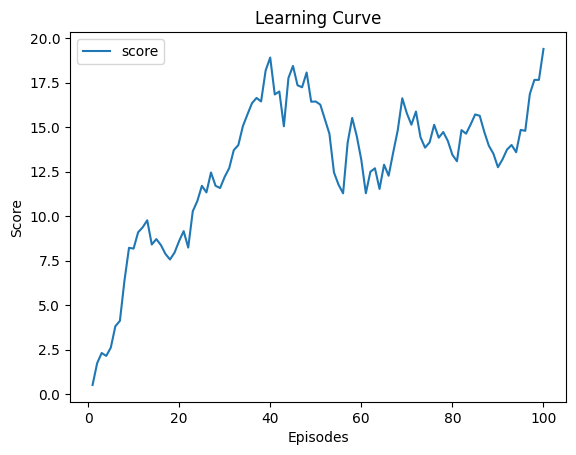

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define a dummy score history for illustration
# Replace this with your actual historical scores if available
dummy_score_history = np.random.randn(100).cumsum()

# Plot the learning curve
def plot_learning_curve(x, scores, filename):
    plt.plot(x, scores, label='score')
    plt.xlabel('Episodes')
    plt.ylabel('Score')
    plt.legend(loc='upper left')
    plt.title('Learning Curve')
    plt.savefig(filename)
    plt.show()

# Plot the learning curve with dummy data
x_dummy = np.arange(1, len(dummy_score_history) + 1)
filename_dummy = 'dummy_learning_curve.png'
plot_learning_curve(x_dummy, dummy_score_history, filename_dummy)


In [11]:
import numpy as np

# Define the calculate_profit function
def calculate_profit(qty, action, current_price, symbol, api):
    position = api.get_position(symbol)

    if action == 'buy':
        return 0  # Profit is not calculated for buy actions
    elif action == 'sell':
        # Calculate profit for sell action without considering buying price
        if position:
            average_price = float(position.avg_entry_price)
            print(f"The average buying price of {symbol} is ${average_price:.2f}")
            return qty * (current_price - average_price)
        else:
            print(f"You don't have a position in {symbol}")
            return 0
    else:
        return 0  # No profit for hold actions

# Your existing code
symbol = 'AAPL'  # Change this to the desired stock symbol
qty = 1  # Change this to the desired quantity

# Choose action using the loaded actor model
dummy_observation = np.random.random((len(env.df.columns),))
probs = agent.actor.predict(np.expand_dims(dummy_observation, axis=0))
action = np.argmax(probs)

# Perform buy or sell based on the chosen action
current_position = int(api.get_position(symbol).qty) if api.get_position(symbol) else 0
current_price = api.get_latest_trade(symbol).price

# Check available buying power
account_info = api.get_account()
buying_power = float(account_info.buying_power)
order_amount = qty * current_price  # Assuming 'current_price' is the current price of the stock

if action == 0:  # Buy
    if order_amount <= buying_power:
        print(f'Agent is buying {qty} shares of {symbol} at a price of ${current_price:.2f} each.')
        api.submit_order(
            symbol=symbol,
            qty=qty,
            side='buy',
            type='market',
            time_in_force='gtc'
        )
    else:
        print('Insufficient buying power to execute buy order.')
elif action == 1:  # Sell
    # Check if the agent has enough shares to sell
    if qty <= current_position:
        print(f'Agent is selling {qty} shares of {symbol} at a price of ${current_price:.2f} each.')
        api.submit_order(
            symbol=symbol,
            qty=qty,
            side='sell',
            type='market',
            time_in_force='gtc'
        )
        # Calculate and display profit for sell action
        profit = calculate_profit(qty, 'sell', current_price, symbol, api)
        print(f'Profit after selling: ${profit:.2f}')
    else:
        print('Insufficient shares to execute sell order.')
else:  # Hold
    print('Agent is holding.')


1/1 [==============================] - 0s 22ms/step
Agent is selling 1 shares of AAPL at a price of $189.80 each.
The average buying price of AAPL is $189.25
Profit after selling: $0.55
